In [ ]:
# Four reward plots: absolute, relative, exponential (k=5), exponential (k=15)
from nn_laser_stabilizer.envs.reward import (
    AbsoluteErrorReward,
    ExponentialErrorReward,
    RelativeErrorReward,
)

# Ensure df exists
if 'df' not in globals():
    raise RuntimeError('DataFrame df is not defined. Run previous cells to load logs.')

# Ensure required columns exist
if not {'process_variable','setpoint'}.issubset(df.columns):
    raise RuntimeError('Columns process_variable and setpoint are required to compute rewards.')

# Instantiate rewards
abs_reward = AbsoluteErrorReward()
rel_reward = RelativeErrorReward()
exp_reward_k5 = ExponentialErrorReward(k=5.0)
exp_reward_k15 = ExponentialErrorReward(k=15.0)

# Compute columns
df['reward_absolute'] = [abs_reward(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]
df['reward_relative'] = [rel_reward(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]
df['reward_exponential_k5'] = [exp_reward_k5(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]
df['reward_exponential_k15'] = [exp_reward_k15(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]

# Plot
import matplotlib.pyplot as plt

x = df['step'] if 'step' in df.columns else range(len(df))
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

axes[0,0].plot(x, df['reward_absolute'], color='tab:blue', linewidth=1.0)
axes[0,0].set_title('AbsoluteErrorReward')
axes[0,0].set_ylabel('reward')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(x, df['reward_relative'], color='tab:orange', linewidth=1.0)
axes[0,1].set_title('RelativeErrorReward')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(x, df['reward_exponential_k5'], color='tab:green', linewidth=1.0)
axes[1,0].set_title('ExponentialErrorReward (k=5)')
axes[1,0].set_xlabel('step')
axes[1,0].set_ylabel('reward')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(x, df['reward_exponential_k15'], color='tab:red', linewidth=1.0)
axes[1,1].set_title('ExponentialErrorReward (k=15)')
axes[1,1].set_xlabel('step')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Анализ результатов эксперимента от 26.09.25

In [1]:
%load_ext autoreload
%autoreload 2

## Описание эксперимента

Перебор коэффициентов по равномерной сетке.

## Результаты

In [2]:
from pathlib import Path

EXPERIMENT_NAME = "pid_grid_scan"
EXPERIMENT_DATE = "2025-09-26"
EXPERIMENT_TIME = "16-48-36"

PATH_TO_EXP_DIR = Path(f"../experiments/{EXPERIMENT_NAME}/{EXPERIMENT_DATE}/{EXPERIMENT_TIME}")
LOG_DIR = PATH_TO_EXP_DIR / "logs"

In [3]:
import pandas as pd
import re
from collections import defaultdict

def parse_pid_logfile(path: str) -> pd.DataFrame:
    """
    Читает лог PID-контроллера из файла и возвращает DataFrame.
    Для каждого step объединяет send и recv в одну строку.
    """
    pattern = re.compile(r"(\w+)=([0-9.+-eE]+)")
    steps = defaultdict(dict)

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split(maxsplit=3)
            step = int(parts[0].split("=")[1])
            timestamp = float(parts[1].split("=")[1])
            direction = parts[2]  # send / recv

            steps[step][f"time_{direction}"] = timestamp

            if len(parts) > 3:
                for key, value in pattern.findall(parts[3]):
                    steps[step][key] = float(value)

    df = pd.DataFrame.from_dict(steps, orient="index").reset_index()
    df = df.rename(columns={"index": "step"})
    return df.sort_values("step").reset_index(drop=True)


In [4]:
log_df = parse_pid_logfile(LOG_DIR / "log.txt")

In [5]:
print(log_df.head())

   step     time_send   kp    ki     kd   u_min   u_max     time_recv  \
0     0  1.758891e+09  3.5  11.0  0.002  2000.0  4095.0  1.758891e+09   
1     1  1.758891e+09  3.5  11.0  0.002  2000.0  4095.0  1.758891e+09   
2     2  1.758891e+09  3.5  11.0  0.002  2000.0  4095.0  1.758891e+09   
3     3  1.758891e+09  3.5  11.0  0.002  2000.0  4095.0  1.758891e+09   
4     4  1.758891e+09  3.5  11.0  0.002  2000.0  4095.0  1.758891e+09   

   process_variable  control_output  
0            1240.0             0.0  
1            1240.0          2000.0  
2            1240.0          2000.0  
3            1060.0          2056.0  
4            1610.0          2000.0  


In [6]:
print(log_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251000 entries, 0 to 250999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              251000 non-null  int64  
 1   time_send         251000 non-null  float64
 2   kp                251000 non-null  float64
 3   ki                251000 non-null  float64
 4   kd                251000 non-null  float64
 5   u_min             251000 non-null  float64
 6   u_max             251000 non-null  float64
 7   time_recv         251000 non-null  float64
 8   process_variable  251000 non-null  float64
 9   control_output    251000 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 19.1 MB
None


In [7]:
print(log_df.describe())

                step     time_send             kp             ki  \
count  251000.000000  2.510000e+05  251000.000000  251000.000000   
mean   125499.500000  1.758892e+09       8.729084      27.434263   
std     72457.603121  5.224693e+02       4.129827      12.979475   
min         0.000000  1.758891e+09       2.916700       9.166700   
25%     62749.750000  1.758891e+09       5.833300      18.333300   
50%    125499.500000  1.758892e+09       8.750000      27.500000   
75%    188249.250000  1.758892e+09      11.666700      36.666700   
max    250999.000000  1.758893e+09      14.583300      45.833300   

                  kd          u_min     u_max     time_recv  process_variable  \
count  251000.000000  251000.000000  251000.0  2.510000e+05     251000.000000   
mean        0.004988       7.976096    4095.0  1.758892e+09       1200.729044   
std         0.002351     126.050135       0.0  5.224693e+02         57.099213   
min         0.001700       0.000000    4095.0  1.758891e+09    

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_df(ax, df, tags=None, title="Training curves"):
    for tag in tags:
        sns.lineplot(data=df, x="step", y=tag, ax=ax, label=tag)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Step")
    ax.set_ylabel("Value")
    ax.legend(title="Metric")

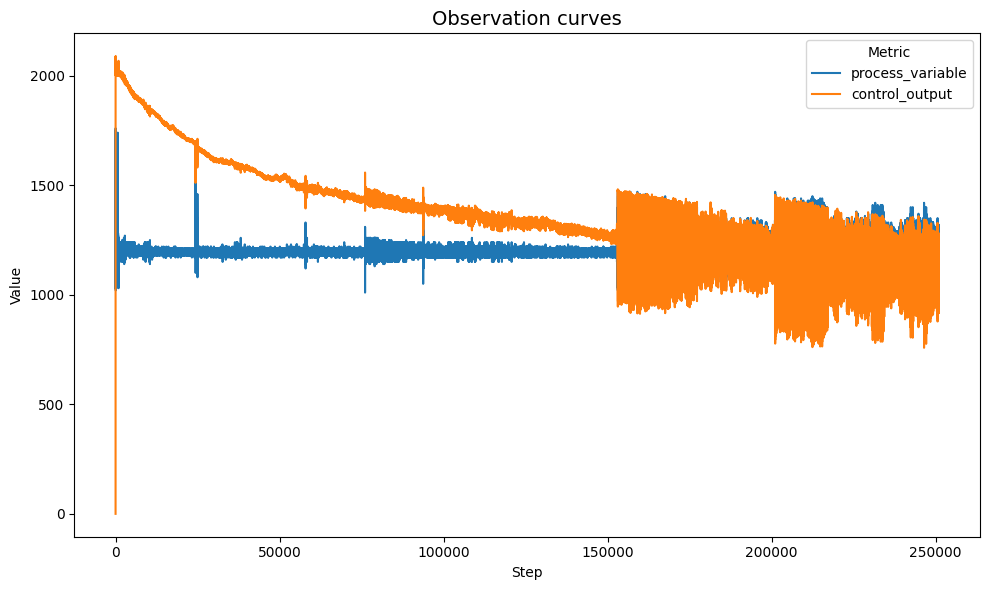

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df(ax, log_df, tags=["process_variable", "control_output"], title="Observation curves")
plt.tight_layout()
plt.savefig(LOG_DIR / "logs.pdf")

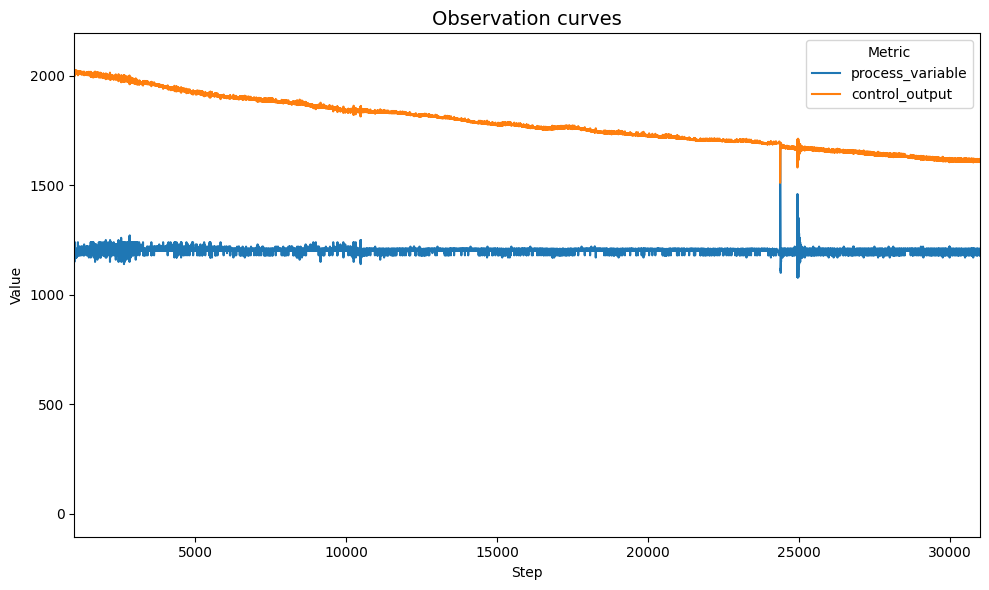

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df(ax, log_df, tags=["process_variable", "control_output"], title="Observation curves")
ax.set_xlim(left=1000, right=31_000)
plt.tight_layout()

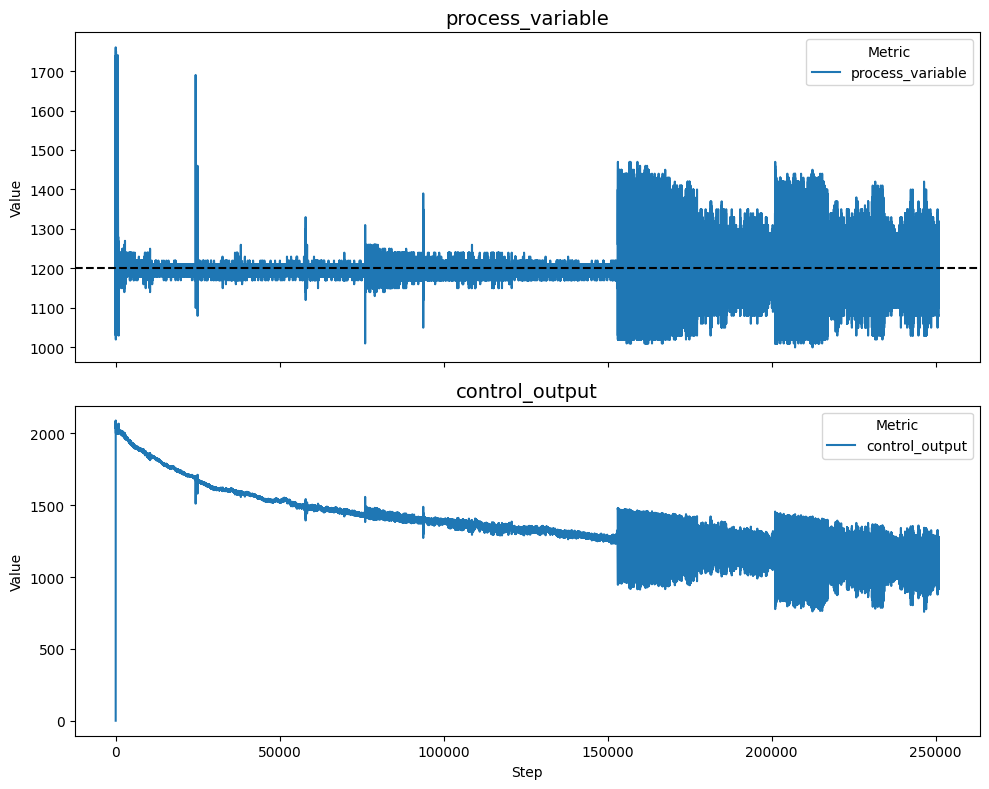

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

tags=["process_variable", "control_output"]
titles = tags

for ax, tag, title in zip(axes, tags, titles):
    plot_df(ax, log_df, tags=[tag], title=title)

    if tag == "process_variable":
        ax.axhline(y=1200, color="black", linestyle="--")

plt.tight_layout()
plt.savefig(LOG_DIR / "observation_logs_split.pdf")

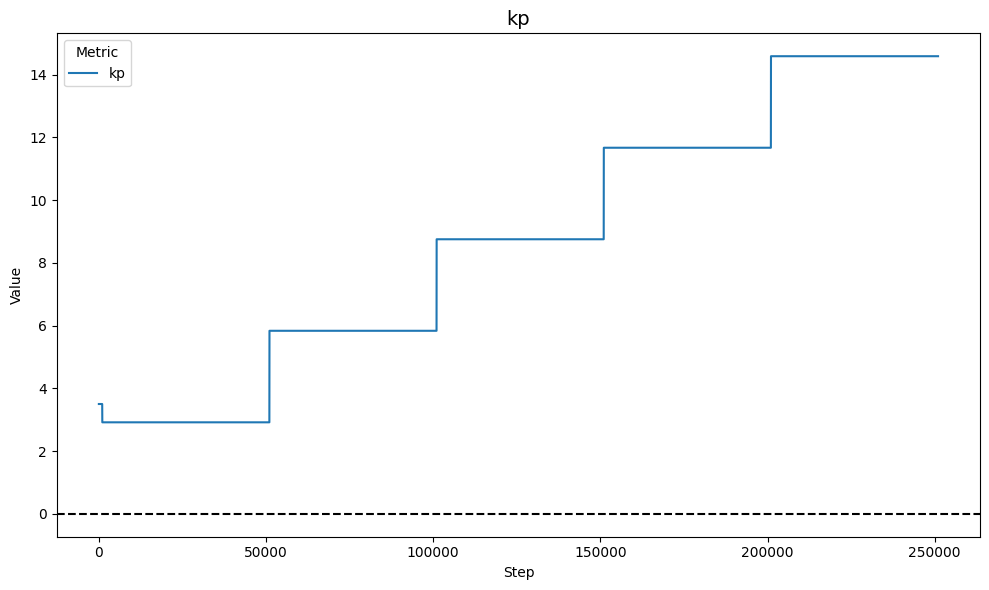

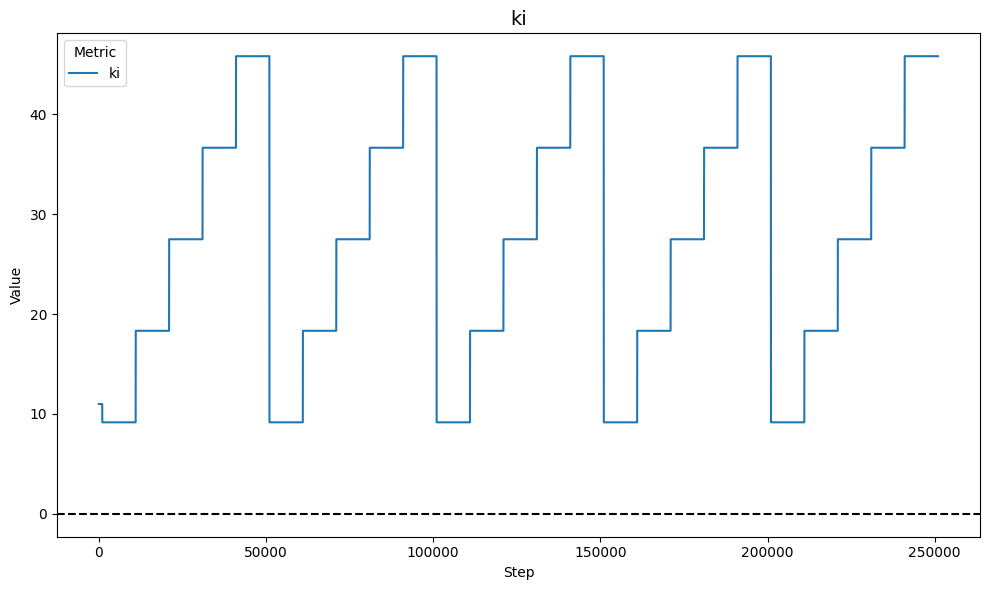

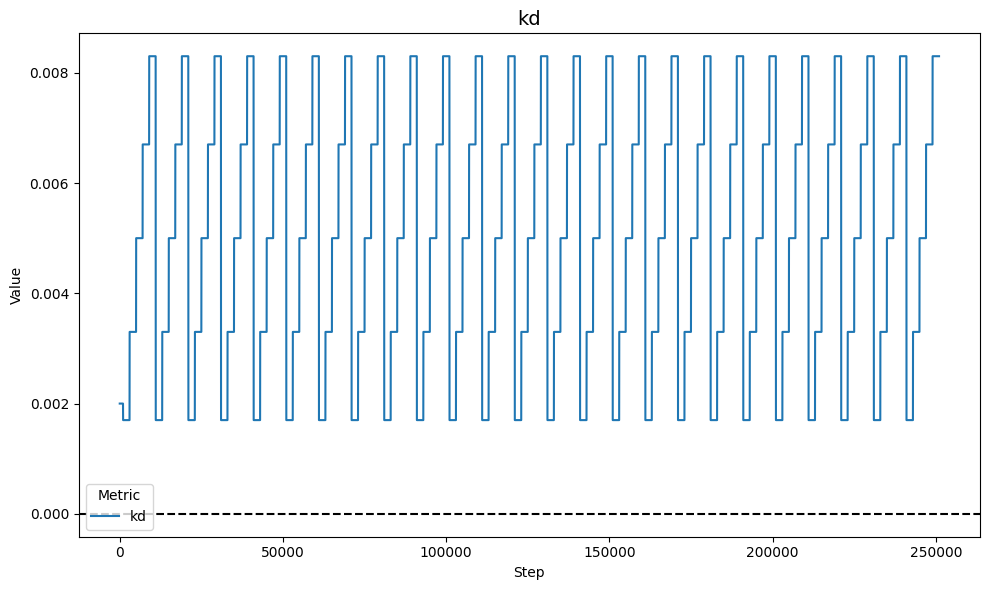

In [12]:
action_tags = ["kp", "ki", "kd"]

for tag in action_tags:
    fig, ax = plt.subplots(figsize=(10, 6))

    plot_df(ax, log_df, tags=[tag], title=tag)

    ax.axhline(y=0, color="black", linestyle="--")

    plt.tight_layout()
    plt.savefig(LOG_DIR / f"{tag.replace('/', '_')}.pdf")

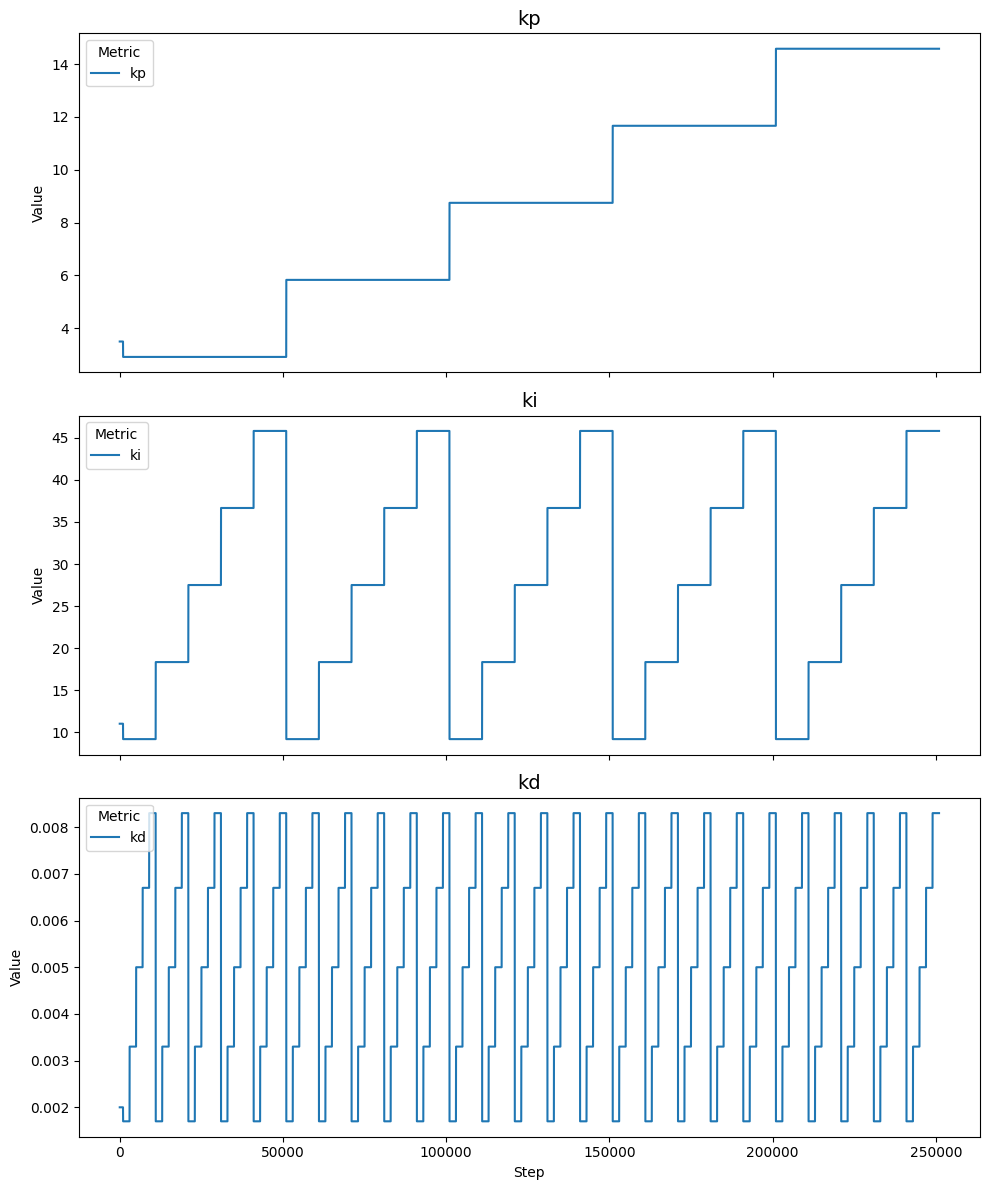

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

tags=action_tags
titles = tags

for ax, tag, title in zip(axes, tags, titles):
    plot_df(ax, log_df, tags=[tag], title=title)

plt.tight_layout()
plt.savefig(LOG_DIR / "action_logs_split.pdf")

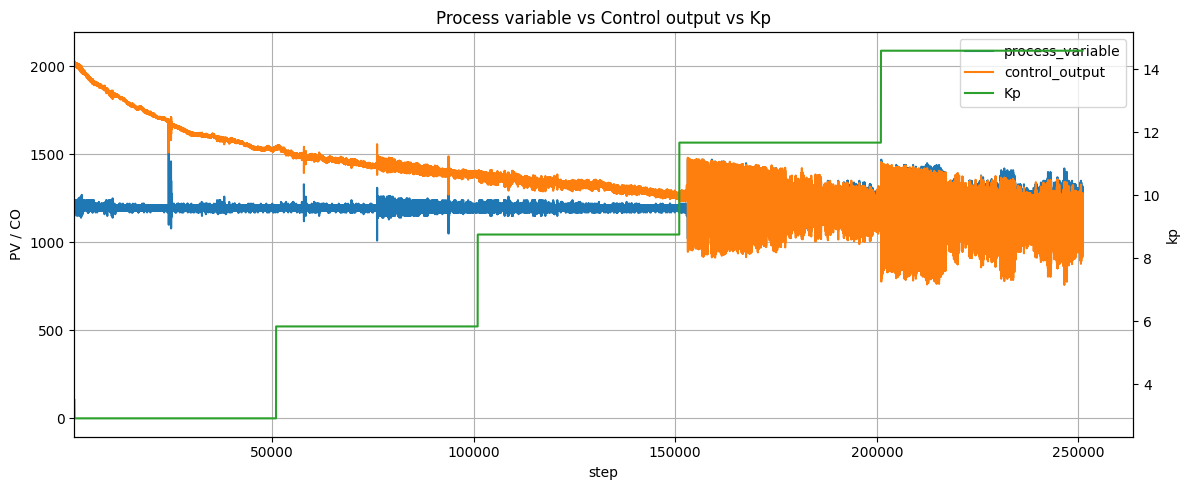

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 5))
df = log_df

x = df['step']

ax1.plot(x, df['process_variable'], label='process_variable', color='tab:blue')
ax1.plot(x, df['control_output'], label='control_output', color='tab:orange')
ax1.set_xlabel('step')
ax1.set_ylabel('PV / CO')
ax1.grid(True)
ax1.set_xlim(left=1000)

ax2 = ax1.twinx()
if 'kp' in df.columns:
    ax2.plot(x, df['kp'], label='Kp', color='tab:green')
ax2.set_ylabel('kp')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)
plt.title('Process variable vs Control output vs Kp')
plt.tight_layout()
plt.show()

In [15]:
from nn_laser_stabilizer.envs.reward import (
    AbsoluteErrorReward,
    ExponentialErrorReward,
    RelativeErrorReward,
)

abs_reward = AbsoluteErrorReward()
exp_reward = ExponentialErrorReward() 
rel_reward = RelativeErrorReward()

if {'process_variable','setpoint'}.issubset(df.columns):
    df['reward_absolute'] = [abs_reward(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]
    df['reward_exponential'] = [exp_reward(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]
    df['reward_relative'] = [rel_reward(pv, sp) for pv, sp in zip(df['process_variable'], df['setpoint'])]

    cols_to_show = ['step','reward_absolute','reward_exponential','reward_relative']
    if 'step' not in df.columns:
        df['step'] = range(len(df))
    display(df[cols_to_show].tail(10))
else:
    print('Columns process_variable and setpoint are required to compute rewards.')

Columns process_variable and setpoint are required to compute rewards.
